# TSA Video GAN

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd /content/drive/'My Drive'/PARMA/OpticalFlow/GitRepo/DatasetGenerator/VGANN
!ls

/content/drive/My Drive/PARMA/OpticalFlow/GitRepo/DatasetGenerator/VGANN
training_checkpoints  TSA_Video_GAN.ipynb


## Imports

Select tensorflow 2.x

In [3]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
tf.__version__

import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import cv2

from IPython import display

## Model Definition

### Creating the custom combination layer for the generator

In [0]:
class MergeLayer(layers.Layer):
  def __init__(self):
    super(MergeLayer, self).__init__()
 
  @tf.function
  def call(self, fg, mask, bg):

    # Fix bg shape 
    fixed_bg = tf.stack([bg] * 32) 
    fixed_bg = tf.transpose(fixed_bg, perm=[1, 2, 3, 0, 4])
    
    return tf.add( tf.multiply(mask, fg), tf.multiply(tf.add(-1.0, mask), fixed_bg) )


### Generator

In [0]:
def Two_Streams_Generator():
    """
      This function creates a two stream generator architecture based on 
      generating-videos-with-scene-dynamics paper
    """


    # Recive the latent space
    latent_space = tf.keras.Input(shape=(100,))

    # Foreground stream
    # Frist layer
    foreground = layers.Dense(4*4*2 * 512)(latent_space)
    foreground = layers.BatchNormalization()(foreground)
    foreground = layers.ReLU()(foreground)
    # Reshape and assert shape
    foreground = layers.Reshape((4, 4, 2, 512))(foreground)
    # Second layer 
    foreground = layers.Conv3DTranspose(256, (2, 4, 4), 2, padding='same')(foreground)
    foreground = layers.BatchNormalization()(foreground)
    foreground = layers.ReLU()(foreground)
    # Third layer
    foreground = layers.Conv3DTranspose(128, (4, 4, 4), 2, padding='same')(foreground)
    foreground = layers.BatchNormalization()(foreground)
    foreground = layers.ReLU()(foreground)
    # Fourth layer
    foreground = layers.Conv3DTranspose(64, (4, 4, 4), 2, padding='same')(foreground)
    foreground = layers.BatchNormalization()(foreground)
    foreground = layers.ReLU()(foreground)
    # Fifth layer
    # Divide into mask and foreground
    mask = layers.Conv3DTranspose(1, (4, 4, 4), 2, padding='same')(foreground)
    foreground = layers.Conv3DTranspose(3, (4, 4, 4), 2, padding='same')(foreground)
    # Foreground
    foreground = layers.BatchNormalization()(foreground)
    foreground = tf.keras.activations.tanh(foreground)
    # Mask
    mask = layers.BatchNormalization()(mask)
    mask = tf.keras.activations.sigmoid(mask)


    # Background stream
    background = layers.Dense(4*4 * 512)(latent_space)
    background = layers.BatchNormalization()(background)
    background = layers.ReLU()(background)
    # Reshape and assert shape
    background = layers.Reshape((4, 4, 512))(background)
    # Second layer 
    background = layers.Conv2DTranspose(256, (2, 4), 2, padding='same')(background)
    background = layers.BatchNormalization()(background)
    background = layers.ReLU()(background)
    # Third layer 
    background = layers.Conv2DTranspose(128, (4, 4), 2, padding='same')(background)
    background = layers.BatchNormalization()(background)
    background = layers.ReLU()(background)
    # Fourth layer 
    background = layers.Conv2DTranspose(64, (4, 4), 2, padding='same')(background)
    background = layers.BatchNormalization()(background)
    background = layers.ReLU()(background)
    # Fifth layer 
    background = layers.Conv2DTranspose(3, (4, 4), 2, padding='same')(background)
    background = layers.BatchNormalization()(background)
    background = tf.keras.activations.tanh(background)

    foreground = MergeLayer()(foreground, mask, background)
    # Dont compile the model since we want to update its weigths manually
    #model = tf.keras.Model(inputs=latent_space, outputs=[foreground, mask, background], name='TSA_Video_Generator')
    model = tf.keras.Model(inputs=latent_space, outputs=foreground, name='TSA_Video_Generator')

    return model

### Discriminator


In [0]:
def Video_Discrminator():
    """
      This function creates a discriminator capable of recognizing real scenes and
      realisic frame motion
    """

    # Recive the video
    video = tf.keras.Input(shape=(64, 64, 32, 3,))

    # Frist layer
    isReal = layers.Conv3D(64, (4, 4, 4), 2, padding='same')(video)
    isReal = layers.LeakyReLU()(isReal)
    # Second layer
    isReal = layers.Conv3D(128, (4, 4, 4), 2, padding='same')(isReal)
    isReal = layers.BatchNormalization()(isReal)
    isReal = layers.LeakyReLU()(isReal)
    # Third layer
    isReal = layers.Conv3D(256, (4, 4, 4), 2, padding='same')(isReal)
    isReal = layers.BatchNormalization()(isReal)
    isReal = layers.LeakyReLU()(isReal)
    # Fourth layer
    isReal = layers.Conv3D(512, (4, 4, 4), 2, padding='same')(isReal)
    isReal = layers.BatchNormalization()(isReal)
    isReal = layers.LeakyReLU()(isReal)
    # Fifth layer
    isReal = layers.Flatten()(isReal)
    isReal = layers.Dense(1, activation='sigmoid')(isReal)
    
    # Dont compile the model since we want to update its weigths manually
    model = tf.keras.Model(inputs=video, outputs=isReal, name='Video_Discrminator')

    return model

Create models

In [8]:
generator = Two_Streams_Generator()
generator.summary()

discriminator = Video_Discrminator()
discriminator.summary()

Model: "TSA_Video_Generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 16384)        1654784     input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 8192)         827392      input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16384)        65536       dense[0][0]                      
________________________________________________________________________________

Quick test to check everything is ok

(1, 64, 64, 32, 3)


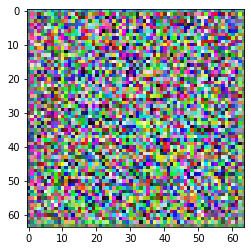

In [28]:
# Generate the seed
latent_space = tf.random.normal([1, 100])
generated_video = generator(latent_space, training=False)
print(generated_video.shape)

# Print discriminator prediction
decision = discriminator(generated_video)

# Plot one generated frame
plot_img = (generated_video[0, :, :, 0, :] * 255 + 127.5).numpy().astype(np.uint8)
#print (decision.eval())
#plt.imshow(tf.dtypes.cast(generated_video[0, :, :, 0, :] * 255 + 127.5, tf.uint8))
plt.imshow(plot_img)

### Defining loss and optimizers

In this case we will use cross entropy since its the recomended by the author

In [0]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real videos from fakes. It compares the discriminator's predictions on real videos to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [0]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [0]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since we will train two networks separately.

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Training

Set checkpoints to important objects

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Set training parameters

In [0]:
EPOCHS = 5000
BATCH_SIZE = 26

noise_dim = 100
num_examples_to_generate = 1
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an video. The discriminator is then used to classify real videos (drawn from the training set) and fakes ones (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [0]:
@tf.function
def train_step(videos, batch_size):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_videos = generator(noise, training=True)

        real_output = discriminator(videos, training=True)
        fake_output = discriminator(generated_videos, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    #print('Generator loss:\t' + str(gen_loss) + '\nDiscriminant loss:\t' + str(disc_loss) )

def get_batch(times, batches):
  frames = 32
  a = times * frames
  video_batch = np.zeros([batches, 64, 64, 32, 3])
  for b in range(batches):
    for i in range(frames):
      a += 1
      # We need the images normaized between [-1,1]
      #print('b: ' + str(b) + '\ti: ' + str(i) + '\ta: ' + str(a))
      video_batch[b, :, :, i, :] = (cv2.resize(cv2.imread("../../Dataset/test/" + str(a) + '.png'), dsize=(64, 64), interpolation=cv2.INTER_CUBIC) - 127.5) / 255
  
  return video_batch

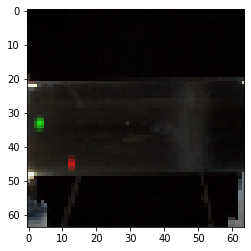

In [17]:
vb = np.zeros([1, 64, 64, 32, 3])
vb[0, :, :, 0, :] = (cv2.resize(cv2.imread("../../Dataset/test/" + str(0) + '.png'), dsize=(64, 64), interpolation=cv2.INTER_CUBIC) - 127.5) / 255
plt.imshow((vb[0, :, :, 0, :] * 255 + 127.5).astype(np.uint8))

In [0]:
def train(epochs, batch_size):
    for epoch in range(epochs):
        start = time.time()

        limit = int(52 / batch_size)

        for i in range(limit):
            video_batch = get_batch(i * batch_size, batch_size)
            train_step(video_batch, batch_size)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
          checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    print(50*'-')
    print('Training finished!')
    print(50*'-')


In [0]:
train(EPOCHS, BATCH_SIZE)

Time for epoch 1 is 7.277345657348633 sec
Time for epoch 2 is 7.310620546340942 sec
Time for epoch 3 is 7.117410182952881 sec
Time for epoch 4 is 7.217644453048706 sec
Time for epoch 5 is 7.104744911193848 sec
Time for epoch 6 is 7.230075836181641 sec
Time for epoch 7 is 7.249445915222168 sec
Time for epoch 8 is 7.745253086090088 sec
Time for epoch 9 is 7.562103033065796 sec
Time for epoch 10 is 7.2514731884002686 sec
Time for epoch 11 is 7.1810266971588135 sec
Time for epoch 12 is 7.152766227722168 sec
Time for epoch 13 is 7.254290819168091 sec
Time for epoch 14 is 7.075538873672485 sec
Time for epoch 15 is 8.399720907211304 sec
Time for epoch 16 is 7.087499141693115 sec
Time for epoch 17 is 7.218908309936523 sec
Time for epoch 18 is 7.099589824676514 sec
Time for epoch 19 is 7.175622224807739 sec
Time for epoch 20 is 7.062416076660156 sec
Time for epoch 21 is 7.16611647605896 sec
Time for epoch 22 is 7.079109191894531 sec
Time for epoch 23 is 7.239684820175171 sec
Time for epoch 24 i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

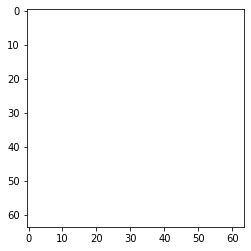

In [22]:
gen_vid = generator(seed)

for i in range(32):
    plt.imshow(gen_vid[0, :, :, i, :].numpy().astype(np.uint8) * 127.5 + 127.5)
    plt.savefig(str(i) + '.png')

Restore the latest checkpoint.

In [0]:
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
#print(tf.train.latest_checkpoint(checkpoint_dir))